# **Project #4 - Food Recognition**
### Deep Learning course - A.Y. 2020-2021
Students:

- Giuseppe	Murro	(0000997317 $-$ giuseppe.murro@studio.unibo.it)
- Salvatore	Pisciotta	(0000985203 $-$ salvatore.pisciotta2@studio.unibo.it)

Install segmentation_models library

In [1]:
!pip install segmentation_models

     |████████████████████████████████| 51kB 7.6MB/s 


Clone the repo in order to access to the dataset

In [2]:
!git clone https://github.com/gmurro/FoodRecognition.git
%cd /content/FoodRecognition/src

/content/FoodRecognition/src


Import useful libraries

In [1]:
import numpy as np
import random
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from utils import segmentation_utils

Define the categories of food on which we want train the segmentation model

In [2]:
cat_names = ['water'
             , 'bread-white'
             , 'salad-leaf-salad-green'
             , 'tomato'
             , 'butter'
             , 'carrot'
             , 'coffee-with-caffeine'
             , 'rice'
             , 'egg'
             , 'mixed-vegetables'
             , 'wine-red'
             , 'apple'
             , 'jam'
             , 'potatoes-steamed'
             , 'banana'
             , 'cheese' ]
             
batch_size = 64
img_size = (128,128)
num_classes = len(cat_names) + 1
num_filters = 32

Define the class `DataGenerator`, which will be used for real-time data feeding to our Keras model.
We make the latter inherit the properties of `keras.utils.Sequence` so that we can leverage nice functionalities such as *multiprocessing*.

In [3]:
class DataGenerator(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, coco, batch_size, img_size, img_ids, img_paths, cat_to_label, aug_args=None, shuffle=True):
        self.coco = coco
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_paths = img_paths
        self.img_ids = img_ids
        self.cat_to_label = cat_to_label
        self.aug_args = aug_args
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """ Number of batches per epoch """
        return len(self.img_ids) // self.batch_size

    def __getitem__(self, idx):
        """ Generate one batch of data """

        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # n of categories
        n_cat = len(self.cat_to_label)

        # Find list of img paths and image ids to read in the batch
        batch_img_paths = [self.img_paths[i] for i in indexes]
        batch_img_ids = [self.img_ids[i] for i in indexes]

        # load imgs
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=np.float32)
        for j, path in enumerate(batch_img_paths):
            img = img_to_array(load_img(path, target_size=self.img_size))
            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size + (n_cat,), dtype=np.float32)
        for j, img_id in enumerate(batch_img_ids):
            mask = segmentation_utils.load_mask(self.coco, img_id, self.cat_to_label)

            # scale down mask
            mask_scaled = np.zeros(self.img_size+ (n_cat,), dtype=np.uint8)
            for i in range(n_cat):
                mask_scaled[:,:,i] = Image.fromarray(mask[:,:,i]).resize(self.img_size, Image.NEAREST)

            y[j] = np.array(mask_scaled, dtype=np.float32)
            
        if self.aug_args is not None:
            x, y = segmentation_utils.augment(x, y, self.aug_args)
            
            #
            
        return x, y

    def on_epoch_end(self):
        """ Method called at the end of every epoch that updates indexes """
        self.indexes = np.arange(len(self.img_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

Test if the DataGenerator works well

In [4]:
# @title Test of the DataGenerator
path_dir = "../data/val/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# parameters for the augmetation
aug_args = dict(
                  rotation_range=5              # @param {type:"slider", min:0, max:10, step:1}
                , width_shift_range=0.01        # @param {type:"slider", min:0, max:0.1, step:0.01}
                , height_shift_range=0.01       # @param {type:"slider", min:0, max:0.1, step:0.01}
                , shear_range=0.01              # @param {type:"slider", min:0, max:0.1, step:0.01}
                , zoom_range=[0.9, 1]           
                , horizontal_flip=True          # @param {type:"boolean"} 
                , vertical_flip=True            # @param {type:"boolean"} 
                , fill_mode='nearest'          #@param ["constant", "nearest", "reflect", "wrap"] {type:"raw"}
                , data_format='channels_last')

# create the generator with augmemtation
data_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths, cat_to_label, aug_args)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [ ]:
# read a batch from the generator
data= data_gen.__getitem__(0)
x = data[0]
y  = data[1]

print("x shape:",x.shape)
print("y shape:",y.shape)

x shape: (32, 128, 128, 3)
y shape: (32, 128, 128, 17)



Image 18


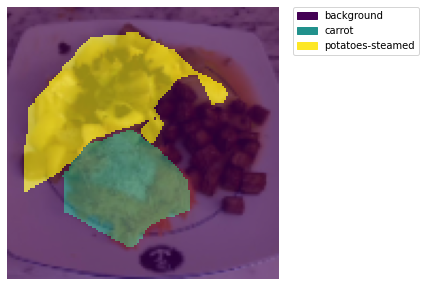


Image 19


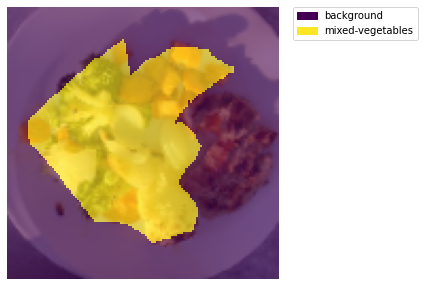


Image 20


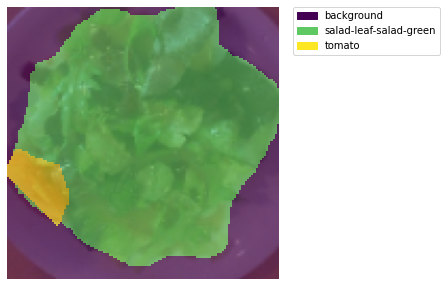

In [ ]:
# read 3 random image from the batches
n = 3

idx = np.random.randint(0, batch_size-1-n)

for i in range(idx,idx+n):
    print("\nImage {}".format(i))
    segmentation_utils.show_mask(x[i,:,:,:]/255, y[i,:,:,:], cat_names)

Test load data without DataGenerator

In [ ]:
# LOAD ALL DATA
x, y = segmentation_utils.load_data(coco, path_dir+"images/", img_size, cat_names)

Loading images:
553/554 [============================>.] - ETA: 0s
Loading masks:
553/554 [============================>.] - ETA: 0s


Image 98


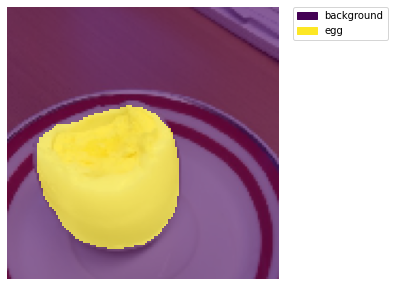

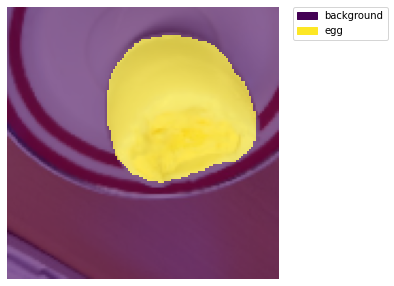


Image 99


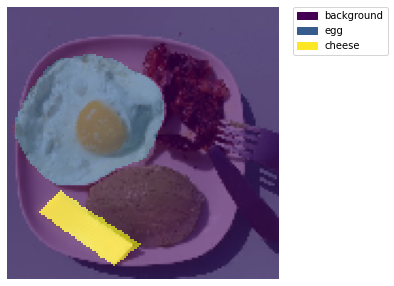

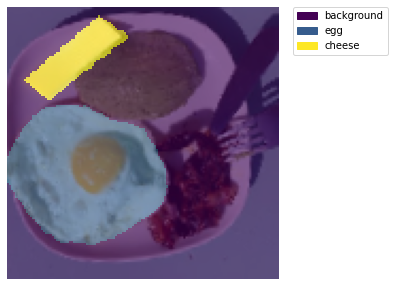


Image 100


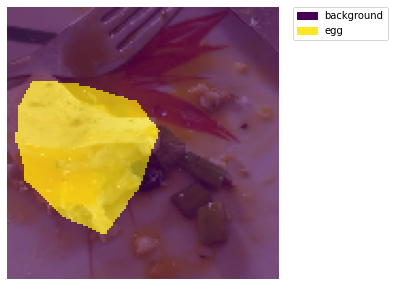

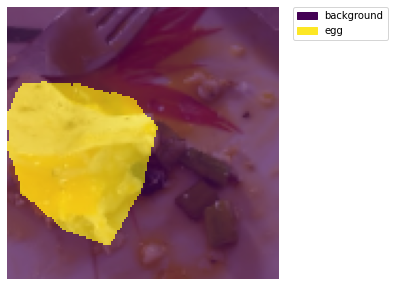

In [ ]:
# show 3 random image and compare with augmentation
n = 3

idx = random.randint(0, len(x)-1-n)

for i in range(idx,idx+n):
    print("\nImage {}".format(i))

    # show image not augmented
    segmentation_utils.show_mask(x[i,:,:]/255, y[i,:,:,:], cat_names)

    # show the same image augmented
    x_p = x[i].reshape((1,)+x[i].shape)
    y_p = y[i].reshape((1,)+y[i].shape)
    x_aug, y_aug = segmentation_utils.augment(x_p, y_p, aug_args)
    segmentation_utils.show_mask(x_aug[0,:,:]/255, y_aug[0,:,:,:], cat_names)

My Custom U-Net

In [4]:
from tensorflow.keras import layers

def conv_block(input, num_filters, size=3, padding='same', initializer="he_normal"):
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def deconv_block(input, num_filters, skip_features, size=2, padding='same', strides=(2, 2)):
    x = layers.Conv2DTranspose(num_filters, kernel_size=(size, size), strides=strides, padding=padding)(input)
    x = layers.concatenate([x, skip_features], axis=3)
    x = conv_block(x, num_filters)
    return x

def unet(img_size, num_classes, num_filters=64):
    
    ''' Input layer '''
    input_layer = layers.Input(shape=img_size + (3,), name='image_input')
    # s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalization
    
    ''' Contractive path '''
    ### Layer 1
    conv1 = conv_block(input_layer, num_filters=num_filters)
    conv1_out = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    ### Layer 2
    conv2 = conv_block(conv1_out, num_filters=num_filters*2)
    conv2_out = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    ### Layer 3
    conv3 = conv_block(conv2_out, num_filters=num_filters*4)
    conv3_out = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    ### Layer 4
    conv4 = conv_block(conv3_out, num_filters=num_filters*8)
    conv4_out = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = layers.Dropout(0.5)(conv4_out)
    
    ### Layer 5
    conv5 = conv_block(conv4_out, num_filters=num_filters*16)
    conv5 = layers.Dropout(0.5)(conv5)
    
    ''' Expansive path '''
    ### Layer 6
    deconv6 = deconv_block(conv5, num_filters=num_filters*8, skip_features=conv4)
    deconv6 = layers.Dropout(0.5)(deconv6)
    
    ### Layer 7
    deconv7 = deconv_block(deconv6, num_filters=num_filters*4, skip_features=conv3,)
    
    ### Layer 8
    deconv8 = deconv_block(deconv7, num_filters=num_filters*2, skip_features=conv2)
    
    ### Layer 9
    deconv9 = deconv_block(deconv8, num_filters=num_filters, skip_features=conv1)
    
    # output: add a per-pixel classification layer
    output_layer = layers.Conv2D(filters=num_classes, kernel_size=(1, 1), activation="softmax", padding="same")(deconv9)
    
    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='u-net')
    return model

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = unet(img_size, num_classes, num_filters=num_filters)
model.summary()

Model: "u-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

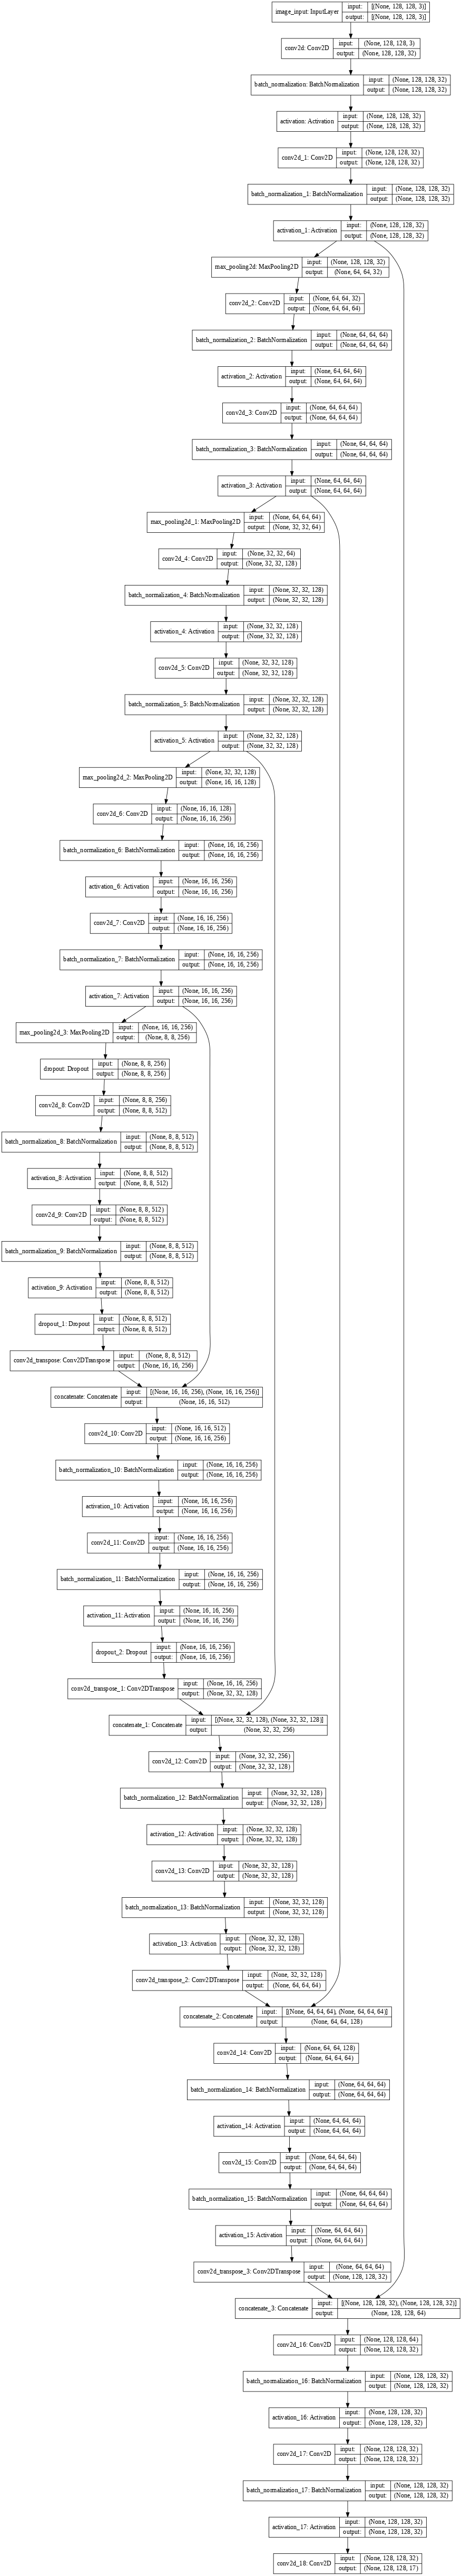

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

Instantiate data Generators for training and validation set

In [5]:
# @title DataGenerator fro training set
path_dir = "../data/train/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

# compute the class weights
class_dist = segmentation_utils.get_class_dist(coco, cat_names)
class_weights = segmentation_utils.get_class_weights(class_dist)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# parameters for the augmetation
aug_args = dict(
                  rotation_range=5              # @param {type:"slider", min:0, max:10, step:1}
                , width_shift_range=0.01        # @param {type:"slider", min:0, max:0.1, step:0.01}
                , height_shift_range=0.01       # @param {type:"slider", min:0, max:0.1, step:0.01}
                , brightness_range=(0.8, 1.2)  
                , shear_range=0.01              # @param {type:"slider", min:0, max:0.1, step:0.01}
                , zoom_range=[0.7, 1]           
                , horizontal_flip=True          # @param {type:"boolean"} 
                , vertical_flip=True            # @param {type:"boolean"} 
                , fill_mode='constant'          #@param ["constant", "nearest", "reflect", "wrap"] {type:"raw"}
                , data_format='channels_last')

# create the generator
train_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths,  cat_to_label, aug_args)

loading annotations into memory...
Done (t=1.75s)
creating index...
index created!


In [7]:
class_weights

array([0.05882353, 0.3468184 , 1.01663221, 0.63136088, 0.49993069,
       1.26775252, 1.26272176, 1.57527665, 0.71266715, 0.53524959,
       1.54468875, 1.01989065, 0.59533374, 1.16772801, 0.96572347,
       0.72649745, 1.41424837])

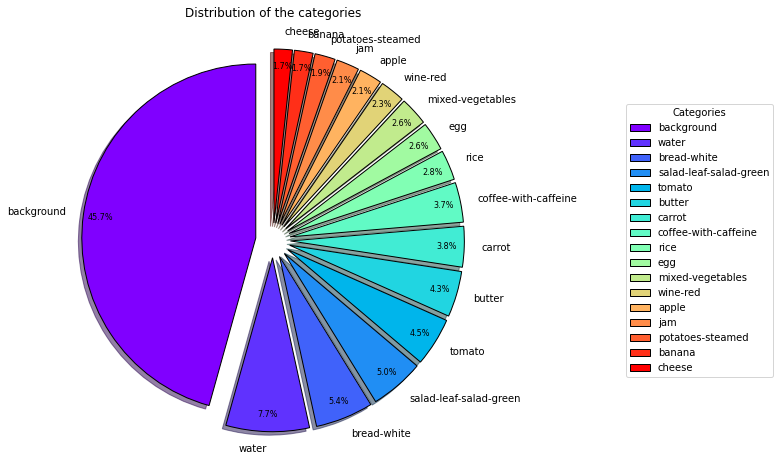

In [6]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

# sort class_distr
class_dist_sorted = dict(sorted(class_dist.items(), key=lambda x:x[1], reverse=True))

# set data
labels = [cat_names[cat_to_label[cat_id]] for cat_id in class_dist_sorted.keys()]
data = list(class_dist_sorted.values())
  
#colors
colors = cm.rainbow(np.linspace(0, 1, len(class_dist_sorted)))

#explsion
explode = [0.1]*len(class_dist_sorted)
  
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
  
  
# Creating plot
fig, ax = plt.subplots(figsize =(12, 8))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct='%1.1f%%',
                                  pctdistance=0.9,
                                  explode = explode, 
                                  labels = labels,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp
                                  )
  
# Adding legend
ax.legend(wedges, labels,
          title ="Categories",
          loc ="center left",
          bbox_to_anchor =(1.3, 0, 0.5, 1))
  
plt.setp(autotexts, size = 8)
ax.set_title("Distribution of the categories")

# show plot
plt.show()

In [7]:
# @title DataGenerator fro training set
path_dir = "../data/val/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# create the generator
val_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths, cat_to_label)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [8]:
%env SM_FRAMEWORK = tf.keras
import segmentation_models as sm

loss = sm.losses.CategoricalFocalLoss() + sm.losses.DiceLoss(class_weights=class_weights)

#loss = sm.losses.categorical_focal_loss

threshold = 0.5
metrics = [tf.keras.metrics.MeanIoU(num_classes=num_classes)
           , sm.metrics.IOUScore(threshold=threshold)
           , sm.metrics.Precision(threshold=threshold)
           , sm.metrics.Recall(threshold=threshold)
           , sm.metrics.FScore(threshold=threshold)]

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [9]:
# Configure the model for training.
from tensorflow.keras.optimizers import *
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
              , loss=loss
              , metrics=metrics)

In [10]:
weights = dict(zip(range(len(cat_names)), class_weights))
weights

{0: 0.058823529411764705,
 1: 0.34681840038467704,
 2: 1.0166322119902274,
 3: 0.6313608776844071,
 4: 0.4999306871216672,
 5: 1.267752519334427,
 6: 1.2627217553688141,
 7: 1.57527664531159,
 8: 0.7126671497266319,
 9: 0.5352495918468313,
 10: 1.5446887492861223,
 11: 1.019890648567119,
 12: 0.5953337368623782,
 13: 1.1677280086346464,
 14: 0.9657234669285013,
 15: 0.7264974482943862,
 16: 1.4142483660130718}

In [11]:
import datetime
cp_file_name = "model/food_segmentation_80_epochs_softmax_cat_focal_dice_loss_128_class_weights_adam_32_filters_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +".h5"

callbacks = [
    #Model checkpoint save weights ad other informations
    tf.keras.callbacks.ModelCheckpoint(cp_file_name, 
                                       monitor = 'loss', # Select which quantity to refers, can also use metrics or the validation 
                                      verbose = 1,
                                      save_best_only = True, 
                                      mode = 'auto', 
                                      save_freq = 'epoch' # Flag to save at each epoch 
                                      )
    , tf.keras.callbacks.TensorBoard(log_dir="model/logs/tensorboard_logs_softmax_cat_focal_dice_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
]

# Train the model, doing validation at the end of each epoch.
epochs = 80
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/80
169/169 [==============================] - 980s 6s/step - loss: 0.9755 - mean_io_u: 0.4703 - iou_score: 0.0607 - precision: 0.5449 - recall: 0.1135 - f1-score: 0.0911 - val_loss: 1.1823 - val_mean_io_u: 0.4707 - val_iou_score: 0.0153 - val_precision: 0.3543 - val_recall: 0.1003 - val_f1-score: 0.0224

Epoch 00001: loss improved from inf to 0.94770, saving model to model\food_segmentation_80_epochs_softmax_cat_focal_dice_loss_128_class_weights_adam_32_filters_20210610-173226.h5
Epoch 2/80
169/169 [==============================] - 958s 6s/step - loss: 0.8877 - mean_io_u: 0.4703 - iou_score: 0.1447 - precision: 0.4309 - recall: 0.2501 - f1-score: 0.2171 - val_loss: 1.0285 - val_mean_io_u: 0.4739 - val_iou_score: 0.0684 - val_precision: 0.2117 - val_recall: 0.2099 - val_f1-score: 0.1083

Epoch 00002: loss improved from 0.94770 to 0.87970, saving model to model\food_segmentation_80_epochs_softmax_cat_focal_dice_loss_128_class_weights_adam_32_filters_20210610-173226.h5
Epoch 3/80

Epoch 18/80
169/169 [==============================] - 962s 6s/step - loss: 0.7520 - mean_io_u: 0.4704 - iou_score: 0.2489 - precision: 0.3892 - recall: 0.4100 - f1-score: 0.3601 - val_loss: 0.8095 - val_mean_io_u: 0.4705 - val_iou_score: 0.2068 - val_precision: 0.3568 - val_recall: 0.3423 - val_f1-score: 0.2954

Epoch 00018: loss did not improve from 0.74733
Epoch 19/80
169/169 [==============================] - 961s 6s/step - loss: 0.7409 - mean_io_u: 0.4705 - iou_score: 0.2579 - precision: 0.3942 - recall: 0.4202 - f1-score: 0.3712 - val_loss: 0.8277 - val_mean_io_u: 0.4709 - val_iou_score: 0.1814 - val_precision: 0.4306 - val_recall: 0.3008 - val_f1-score: 0.2583

Epoch 00019: loss improved from 0.74733 to 0.73787, saving model to model\food_segmentation_80_epochs_softmax_cat_focal_dice_loss_128_class_weights_adam_32_filters_20210610-173226.h5
Epoch 20/80
169/169 [==============================] - 961s 6s/step - loss: 0.7413 - mean_io_u: 0.4703 - iou_score: 0.2568 - precision: 0.39


Epoch 00036: loss did not improve from 0.66448
Epoch 37/80
169/169 [==============================] - 961s 6s/step - loss: 0.6628 - mean_io_u: 0.4706 - iou_score: 0.3249 - precision: 0.4785 - recall: 0.4920 - f1-score: 0.4470 - val_loss: 0.7120 - val_mean_io_u: 0.4707 - val_iou_score: 0.2840 - val_precision: 0.4494 - val_recall: 0.4446 - val_f1-score: 0.3942

Epoch 00037: loss did not improve from 0.66448
Epoch 38/80
169/169 [==============================] - 962s 6s/step - loss: 0.6656 - mean_io_u: 0.4705 - iou_score: 0.3253 - precision: 0.4755 - recall: 0.4965 - f1-score: 0.4480 - val_loss: 0.6763 - val_mean_io_u: 0.4711 - val_iou_score: 0.3077 - val_precision: 0.4935 - val_recall: 0.4577 - val_f1-score: 0.4238

Epoch 00038: loss improved from 0.66448 to 0.66439, saving model to model\food_segmentation_80_epochs_softmax_cat_focal_dice_loss_128_class_weights_adam_32_filters_20210610-173226.h5
Epoch 39/80
169/169 [==============================] - 958s 6s/step - loss: 0.6578 - mean_io

169/169 [==============================] - 963s 6s/step - loss: 0.6012 - mean_io_u: 0.4711 - iou_score: 0.3808 - precision: 0.5399 - recall: 0.5485 - f1-score: 0.5072 - val_loss: 0.6522 - val_mean_io_u: 0.4725 - val_iou_score: 0.3334 - val_precision: 0.5316 - val_recall: 0.4637 - val_f1-score: 0.4461

Epoch 00055: loss did not improve from 0.60322
Epoch 56/80
169/169 [==============================] - 961s 6s/step - loss: 0.6058 - mean_io_u: 0.4712 - iou_score: 0.3762 - precision: 0.5343 - recall: 0.5439 - f1-score: 0.5038 - val_loss: 0.6667 - val_mean_io_u: 0.4721 - val_iou_score: 0.3113 - val_precision: 0.4954 - val_recall: 0.4538 - val_f1-score: 0.4211

Epoch 00056: loss did not improve from 0.60322
Epoch 57/80
169/169 [==============================] - 963s 6s/step - loss: 0.6015 - mean_io_u: 0.4709 - iou_score: 0.3838 - precision: 0.5403 - recall: 0.5517 - f1-score: 0.5088 - val_loss: 0.6553 - val_mean_io_u: 0.4712 - val_iou_score: 0.3357 - val_precision: 0.5554 - val_recall: 0.45

169/169 [==============================] - 966s 6s/step - loss: 0.5507 - mean_io_u: 0.4712 - iou_score: 0.4299 - precision: 0.5885 - recall: 0.5960 - f1-score: 0.5564 - val_loss: 0.6277 - val_mean_io_u: 0.4725 - val_iou_score: 0.3624 - val_precision: 0.5983 - val_recall: 0.4944 - val_f1-score: 0.4759

Epoch 00074: loss did not improve from 0.56116
Epoch 75/80
169/169 [==============================] - 980s 6s/step - loss: 0.5719 - mean_io_u: 0.4712 - iou_score: 0.4142 - precision: 0.5721 - recall: 0.5825 - f1-score: 0.5386 - val_loss: 0.6527 - val_mean_io_u: 0.4734 - val_iou_score: 0.3422 - val_precision: 0.5519 - val_recall: 0.4523 - val_f1-score: 0.4494

Epoch 00075: loss did not improve from 0.56116
Epoch 76/80
169/169 [==============================] - 1030s 6s/step - loss: 0.5577 - mean_io_u: 0.4713 - iou_score: 0.4244 - precision: 0.5847 - recall: 0.5890 - f1-score: 0.5510 - val_loss: 0.6201 - val_mean_io_u: 0.4712 - val_iou_score: 0.3564 - val_precision: 0.5935 - val_recall: 0.4

In [12]:
import matplotlib.pyplot as plt
def plot_history(model_history, keys, labels=("epochs", "metrics"), figsize=(10,5)):
    
    fig = plt.figure(figsize=figsize)
    
    # take all pairs of training and val metrics
    for i in range(0, len(keys), 2):
        m, val_m = keys[i], keys[i+1]
        
        plt.plot(model_history.history[m])
        plt.plot(model_history.history[val_m])
        
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    # Adding legend
    plt.legend(keys,
          title ="Legend",
          loc ="upper left",
          bbox_to_anchor =(1.0, 0, 0.5, 1))
    plt.title("Training history")
    plt.grid(True)
    plt.show()

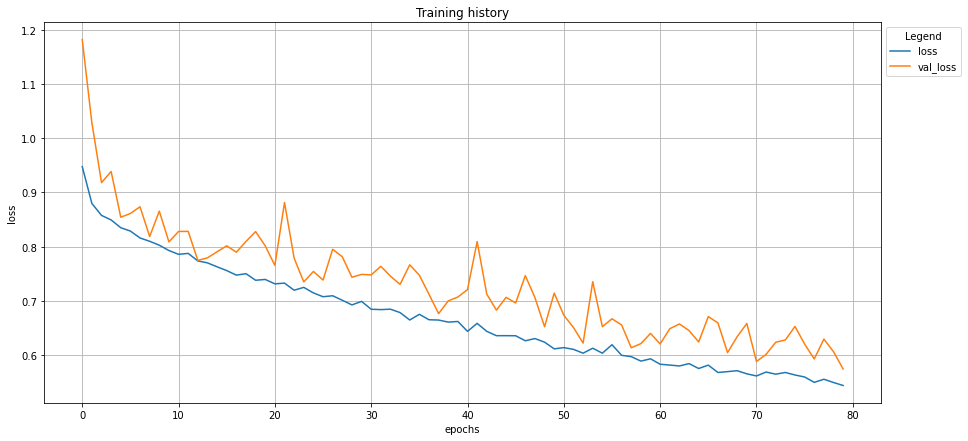

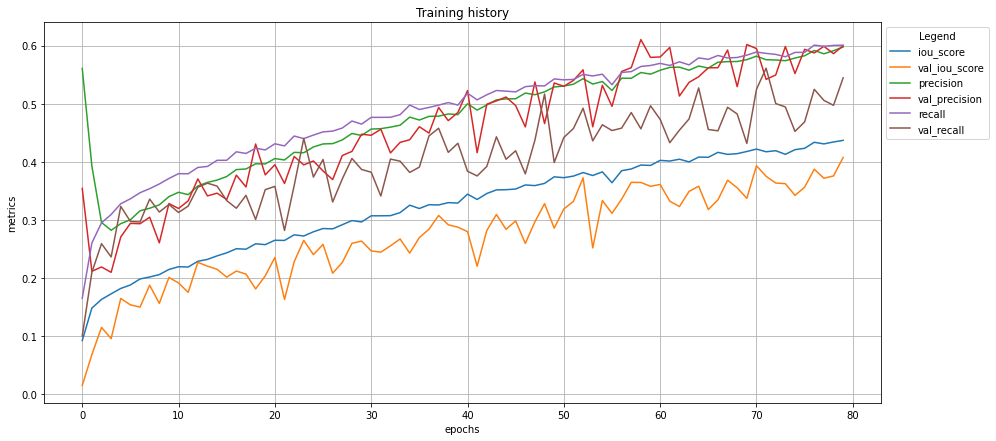

In [13]:
# fit from 0 to 80
plot_history(history,['loss','val_loss'], labels=("epochs", "loss"), figsize=(15,7))
plot_history(history,['iou_score','val_iou_score', 'precision', 'val_precision', 'recall', 'val_recall'], figsize=(15,7))

In [14]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
with open('hist.csv', mode='w') as f:
    hist_df.to_csv(f)

In [31]:
# serialize weights to HDF5
model.save_weights("model_80.h5")

In [ ]:
# if you have pretrained weights, load them here
model.load_weights('model/food_segmentation_focal_60_epochs_20210601-003937.h5')

In [15]:
# LOAD VAL DATA
x, y = segmentation_utils.load_data(coco, "../data/val/images/", img_size, cat_names)

Loading images:
552/554 [============================>.] - ETA: 0s
Loading masks:
552/554 [============================>.] - ETA: 0s

In [16]:
val_preds = model.predict(x)

In [17]:
from keras import backend as K

smooth = 1e-5

def dice_coef(y_true, y_pred):
    y_true = y_true.astype('float32')
    y_pred = y_pred.astype('float32')
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [18]:
def display_mask(i, size=img_size):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.resize(size)
    display(img)
    print(img.size)

def get_pred_mask(pred):
   mask = np.argmax(pred, axis=-1)
   return mask
def binarize(pred, thresold):
   return np.where(pred > thresold, 1., 0.)

In [19]:
class_weights

array([0.05882353, 0.3468184 , 1.01663221, 0.63136088, 0.49993069,
       1.26775252, 1.26272176, 1.57527665, 0.71266715, 0.53524959,
       1.54468875, 1.01989065, 0.59533374, 1.16772801, 0.96572347,
       0.72649745, 1.41424837])

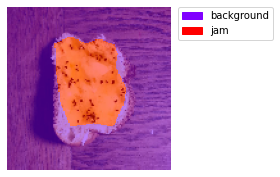

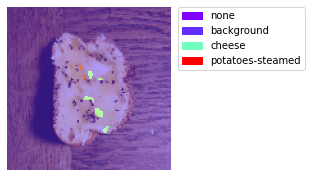

IOU score:  tf.Tensor(0.6767635492277859, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.2715335, shape=(), dtype=float32)
--------------------------------------------------------------


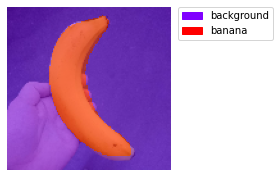

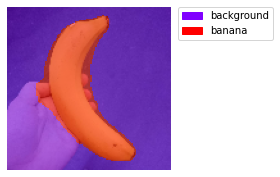

IOU score:  tf.Tensor(0.8990676936133721, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.14553076, shape=(), dtype=float32)
--------------------------------------------------------------


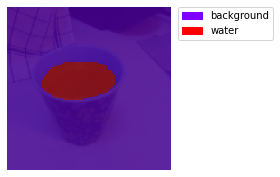

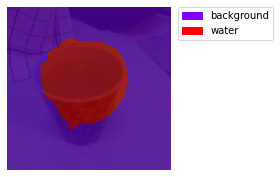

IOU score:  tf.Tensor(0.7826133736174009, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.20761806, shape=(), dtype=float32)
--------------------------------------------------------------


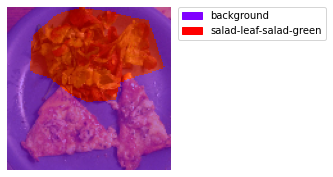

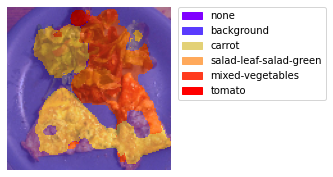

IOU score:  tf.Tensor(0.3572955201983989, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.5248862, shape=(), dtype=float32)
--------------------------------------------------------------


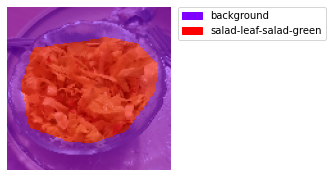

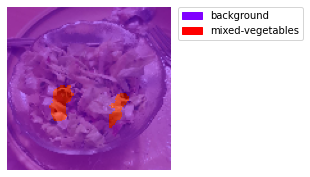

IOU score:  tf.Tensor(0.40249086142884855, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.48203498, shape=(), dtype=float32)
--------------------------------------------------------------


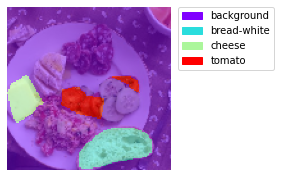

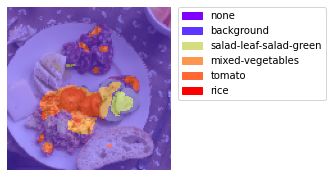

IOU score:  tf.Tensor(0.670898882254591, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.27531147, shape=(), dtype=float32)
--------------------------------------------------------------


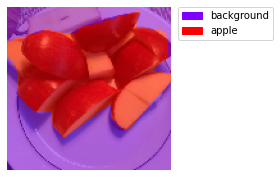

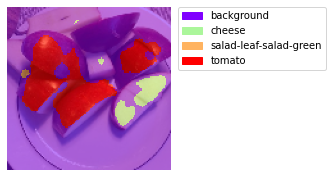

IOU score:  tf.Tensor(0.328507840025461, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.5537008, shape=(), dtype=float32)
--------------------------------------------------------------


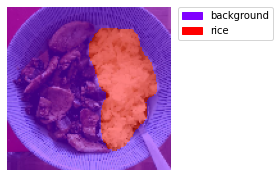

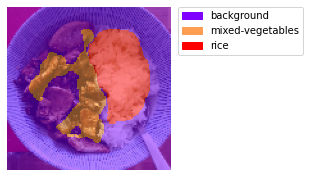

IOU score:  tf.Tensor(0.714544139076626, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.24781466, shape=(), dtype=float32)
--------------------------------------------------------------


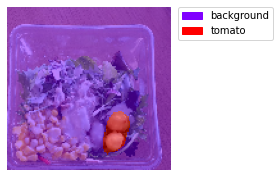

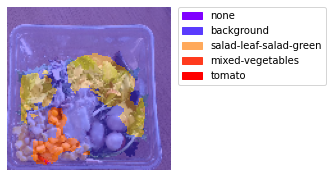

IOU score:  tf.Tensor(0.6511835200301161, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.28820896, shape=(), dtype=float32)
--------------------------------------------------------------


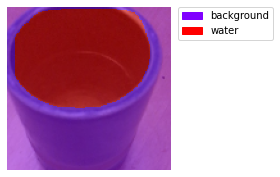

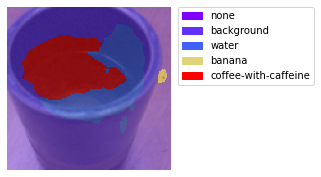

IOU score:  tf.Tensor(0.482077899262675, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.41292894, shape=(), dtype=float32)
--------------------------------------------------------------


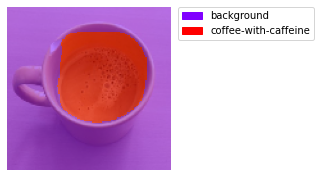

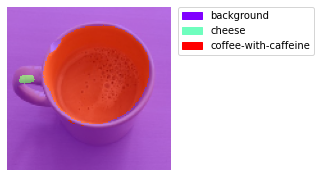

IOU score:  tf.Tensor(0.9094714809526883, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.14035255, shape=(), dtype=float32)
--------------------------------------------------------------


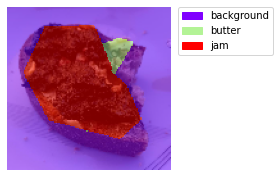

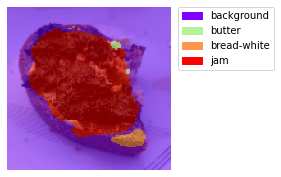

IOU score:  tf.Tensor(0.7895864918241484, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.20367289, shape=(), dtype=float32)
--------------------------------------------------------------


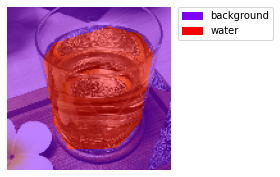

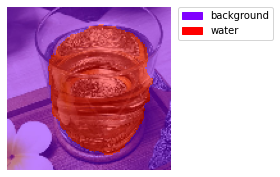

IOU score:  tf.Tensor(0.9149034839053368, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.13767129, shape=(), dtype=float32)
--------------------------------------------------------------


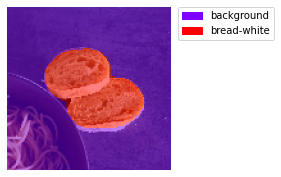

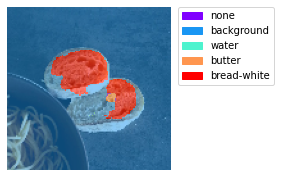

IOU score:  tf.Tensor(0.8055297525788045, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.1947673, shape=(), dtype=float32)
--------------------------------------------------------------


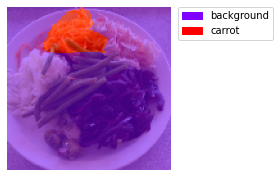

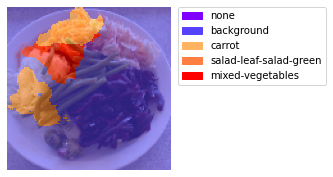

IOU score:  tf.Tensor(0.768300479611987, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.21581316, shape=(), dtype=float32)
--------------------------------------------------------------


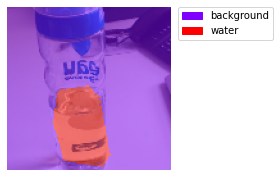

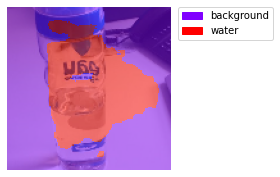

IOU score:  tf.Tensor(0.6010618128550143, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.32242787, shape=(), dtype=float32)
--------------------------------------------------------------


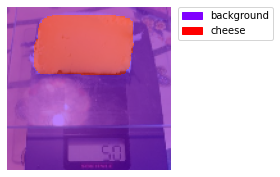

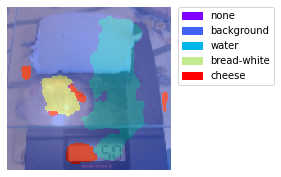

IOU score:  tf.Tensor(0.43681013115563866, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.4512964, shape=(), dtype=float32)
--------------------------------------------------------------


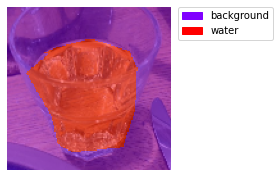

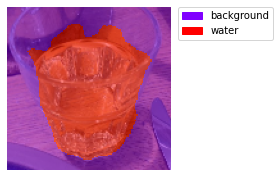

IOU score:  tf.Tensor(0.8503344482439608, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.17056179, shape=(), dtype=float32)
--------------------------------------------------------------


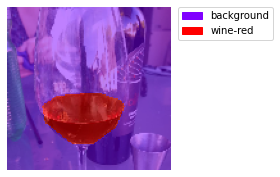

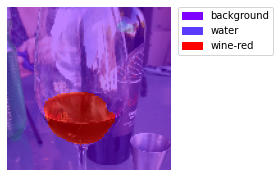

IOU score:  tf.Tensor(0.9512499258053263, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.120114386, shape=(), dtype=float32)
--------------------------------------------------------------


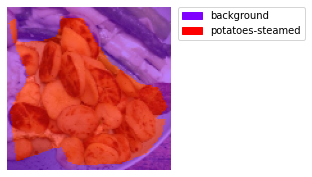

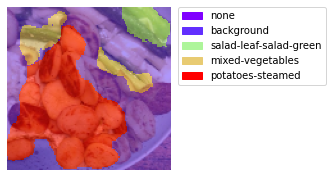

IOU score:  tf.Tensor(0.4940051194512528, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.40320683, shape=(), dtype=float32)
--------------------------------------------------------------


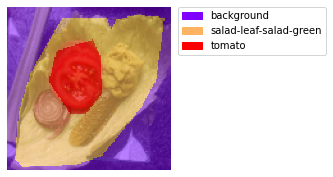

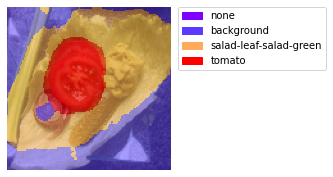

IOU score:  tf.Tensor(0.5713256486080126, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.34376103, shape=(), dtype=float32)
--------------------------------------------------------------


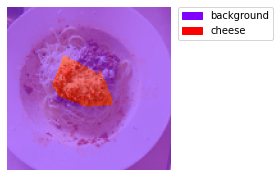

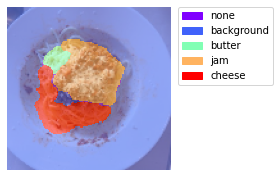

IOU score:  tf.Tensor(0.637261257848072, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.29750377, shape=(), dtype=float32)
--------------------------------------------------------------


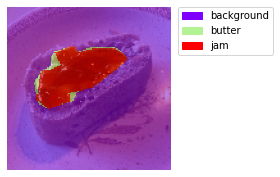

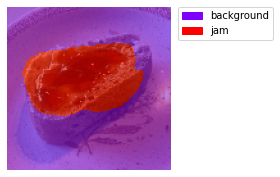

IOU score:  tf.Tensor(0.6893813932345926, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.263494, shape=(), dtype=float32)
--------------------------------------------------------------


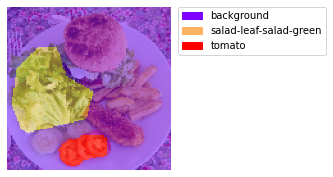

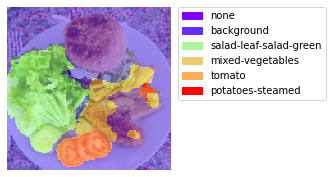

IOU score:  tf.Tensor(0.7277598586371034, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.23976272, shape=(), dtype=float32)
--------------------------------------------------------------


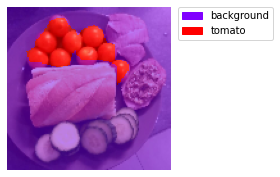

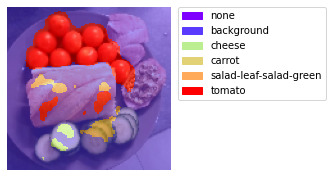

IOU score:  tf.Tensor(0.8274682847063054, shape=(), dtype=float64)
Dice loss:  tf.Tensor(0.18276685, shape=(), dtype=float32)
--------------------------------------------------------------


In [20]:
# Display 5 random predictions
n = 25
np.random.seed(2)
idx = np.random.choice(range(len(val_preds)), n)

imgs = [x[i]/255 for i in idx]
masks = [y[i][:,:,0] for i in idx]
predicions = [get_pred_mask(val_preds[i]) for i in idx]

threshold = 0.4
for i in idx:
    
    segmentation_utils.show_mask(x[i]/255, y[i,:,:,:], cat_names, figsize=(3,3))
    segmentation_utils.show_mask(x[i]/255, binarize(val_preds[i], threshold), cat_names, figsize=(3,3))
    print("IOU score: ",sm.metrics.IOUScore().__call__(y[i,:,:,:], binarize(val_preds[i,:,:,:], threshold)))
    print("Dice loss: ",sm.losses.DiceLoss(class_weights=class_weights).__call__(y[i,:,:,:].astype('float32'), binarize(val_preds[i,:,:,:], threshold).astype('float32')))
    print("--------------------------------------------------------------")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir model/logs/tensorboard_logs_20210531-160755

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9020), started 0:03:15 ago. (Use '!kill 9020' to kill it.)

In [ ]:
!taskkill /PID 9020 /F

OPERAZIONE RIUSCITA: il processo con il PID 9020 Š stato terminato.


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir model/logs/tensorboard_logs_60_20210601-003937

Reusing TensorBoard on port 6006 (pid 18460), started 0:03:04 ago. (Use '!kill 18460' to kill it.)

In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)